In [64]:
import os

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import yaml
from icecream import ic

from bandit_sim.configs import AlgorithmConfig, BanditEnvConfig
from bandit_sim.setting import Settings, generate_base_filename

In [65]:
result_dir = "20250818-1408-alignment"
output_dir = os.path.join("../output/", result_dir)

config = {}

with open(os.path.join(output_dir, "simulation_config.yaml"), "r") as config_file:
    raw_dict = yaml.full_load(config_file)  # TODO: Make config loadable.
    for k, v in raw_dict.items():
        if k == "bandit_env_config":
            config_value = BanditEnvConfig.model_validate(v)
        elif k == "algorithm_configs":
            config_value = [AlgorithmConfig.model_validate(alg_dict) for alg_dict in v]
        elif k == "settings":
            config_value = Settings(**v)
        else:
            config_value = v

        config[k] = config_value

settings: Settings = config["settings"]
algorithms: list[AlgorithmConfig] = config["algorithm_configs"]
bandit_env_config = config["bandit_env_config"]
bandit_env_name = config["bandit_env_name"]

# config
T = settings.T
trials = settings.num_trials
K = settings.num_arms
base_seed = settings.base_seed

num_trials = settings.num_trials
trial_id_overrides = settings.trial_id_overrides

if trial_id_overrides is not None and len(trial_id_overrides) > 0:
    trial_ids = trial_id_overrides
    num_trials = len(trial_ids)
else:
    trial_ids = range(num_trials)

num_algs = len(algorithms)
K_env = K // 2

In [66]:
bandit_env_params = None
filename = generate_base_filename(base_seed)

with open(os.path.join(output_dir, f"bandit_env_params_{filename}"), "rb") as f:
    bandit_env_params = np.load(f)

ic(bandit_env_params.shape)
ic(bandit_env_params)

ic| bandit_env_params.shape: (1, 16, 2)
ic| bandit_env_params: array([[[0.77027396, 0.92191139],
                               [0.39307954, 0.221746  ],
                               [0.84712877, 0.08092513],
                               [0.88033275, 0.12818366],
                               [0.74389138, 0.19017646],
                               [0.99864663, 0.91989586],
                               [0.89144644, 0.73209839],
                               [0.87017906, 0.3872424 ],
                               [0.02698119, 0.7817398 ],
                               [0.85200952, 0.09237773],
                               [0.26232109, 0.78414189],
                               [0.91267919, 0.05350334],
                               [0.70267867, 0.38304689],
                               [0.2244278 , 0.88503693],
                               [0.83091205, 0.37974875],
                               [0.45569454, 0.08458546]]])


array([[[0.77027396, 0.92191139],
        [0.39307954, 0.221746  ],
        [0.84712877, 0.08092513],
        [0.88033275, 0.12818366],
        [0.74389138, 0.19017646],
        [0.99864663, 0.91989586],
        [0.89144644, 0.73209839],
        [0.87017906, 0.3872424 ],
        [0.02698119, 0.7817398 ],
        [0.85200952, 0.09237773],
        [0.26232109, 0.78414189],
        [0.91267919, 0.05350334],
        [0.70267867, 0.38304689],
        [0.2244278 , 0.88503693],
        [0.83091205, 0.37974875],
        [0.45569454, 0.08458546]]])

```
array([[0.77027396, 0.92191139],
       [0.39307954, 0.221746  ],
       [0.84712877, 0.08092513],
       [0.88033275, 0.12818366],
       [0.74389138, 0.19017646],
       [0.99864663, 0.91989586],
       [0.89144644, 0.73209839],
       [0.87017906, 0.3872424 ],
       [0.02698119, 0.7817398 ],
       [0.85200952, 0.09237773],
       [0.26232109, 0.78414189],
       [0.91267919, 0.05350334],
       [0.70267867, 0.38304689],
       [0.2244278 , 0.88503693],
       [0.83091205, 0.37974875],
       [0.45569454, 0.08458546]])
```

In [67]:
raw_df = pl.DataFrame()

for i, trial_id in enumerate(trial_ids):
    filename = generate_base_filename(base_seed, trial_id)
    with open(os.path.join(output_dir, f"data_{filename}"), "rb") as f:
        raw_df.vstack(pl.read_parquet(f), in_place=True)

raw_df

reward,action,info_ratio,r_star,algorithm,time_step,regret,trial
f64,u8,f64,f64,cat,u32,f64,u16
0.387242,7,0.478071,0.803872,"""IDS""",0,0.531517,7
0.128184,3,0.477045,0.803545,"""IDS""",1,1.322093,7
0.21826,8,0.477497,0.803689,"""IDS""",2,2.022592,7
0.379749,14,0.476733,0.803446,"""IDS""",3,2.561602,7
0.084585,15,0.477653,0.803739,"""IDS""",4,3.395776,7
…,…,…,…,…,…,…,…
0.919896,5,3.623095,0.882318,"""IDS""",39995,951.8889,7
0.919896,5,3.622881,0.882318,"""IDS""",39996,951.887764,7
0.919896,5,3.623186,0.882319,"""IDS""",39997,951.886627,7


In [68]:
aggregated_df = (
    raw_df.group_by("algorithm", "time_step")
    .agg(
        pl.col("regret").mean().alias("regret mean"),
        pl.col("regret").std().alias("regret std"),
        pl.col("info_ratio").mean().alias("info ratio mean"),
        pl.col("info_ratio").std().alias("info ratio std"),
    )
    .sort("time_step")
)

grouped_df = aggregated_df.group_by("algorithm")

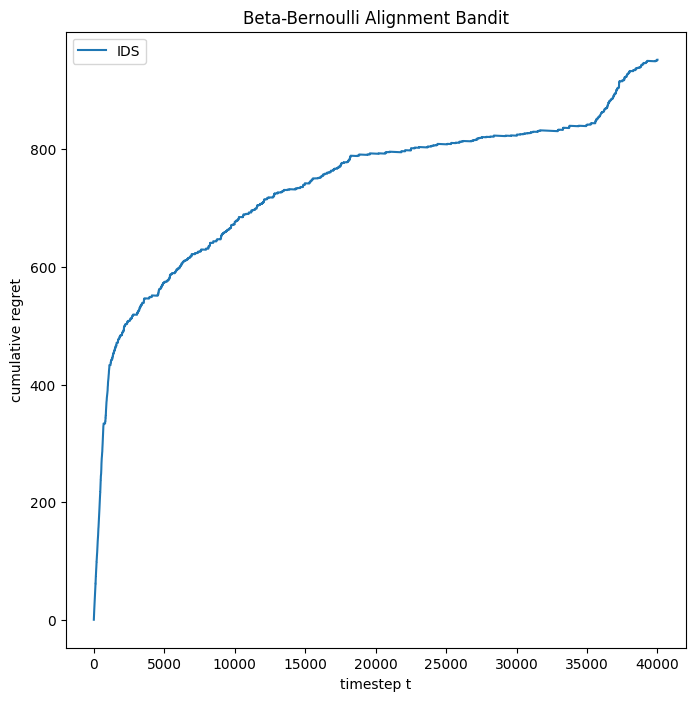

In [69]:
"""
Section below is for plotting
"""
title = bandit_env_name
output = bandit_env_config.label

plt.figure(figsize=(8, 8))

for alg_name, data in grouped_df:
    means = data["regret mean"]
    stds = data["regret std"]
    plt.plot(
        np.arange(T),
        means,
        label=alg_name,
    )
    plt.fill_between(
        np.arange(T),
        means + stds,
        means - stds,
        alpha=0.3,
    )

plt.title(title)
plt.xlabel("timestep t")
plt.ylabel("cumulative regret")
plt.legend()
plt.show()

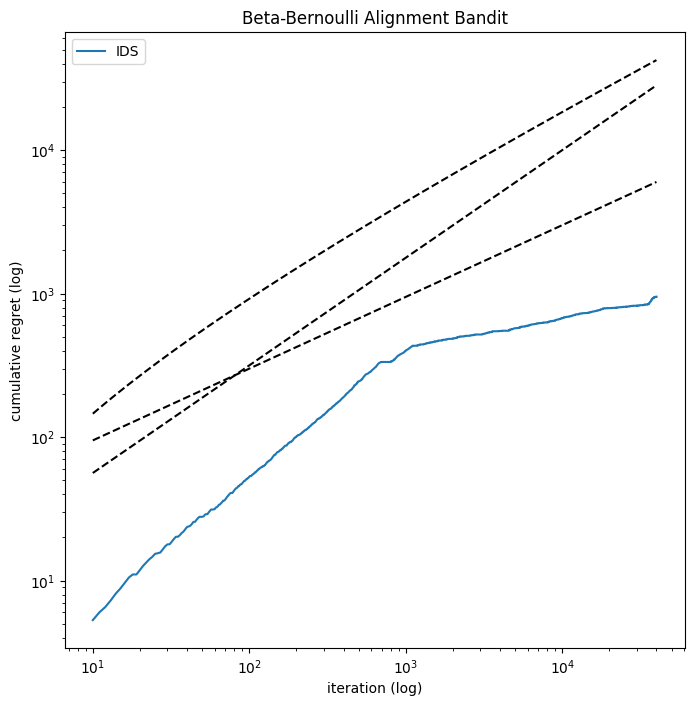

In [70]:
# log log plot
plt.figure(figsize=(8, 8))

for alg_name, data in grouped_df:
    means = data["regret mean"]
    stds = data["regret std"]
    plt.plot(
        np.arange(10, T),
        means[10:],
        label=alg_name,
    )
    plt.fill_between(
        np.arange(10, T),
        means[10:] + stds[10:],
        means[10:] - stds[10:],
        alpha=0.3,
    )
# lines for comparison
x = np.arange(10, T)
sqrt_x = 30 * np.sqrt(x)
sqrt_x_log_x = 20 * np.sqrt(x) * np.log(x)
x_3_4 = 10 * x ** (3 / 4)

# plt.plot(x, x, "k--")
plt.plot(x, sqrt_x, "k--")
plt.plot(x, sqrt_x_log_x, "k--")
plt.plot(x, x_3_4, "k--")
# plt.xlim(left=0, right=T)
# plt.ylim(bottom=0, top=120)
plt.title(title)
plt.xlabel("iteration (log)")
plt.ylabel("cumulative regret (log)")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

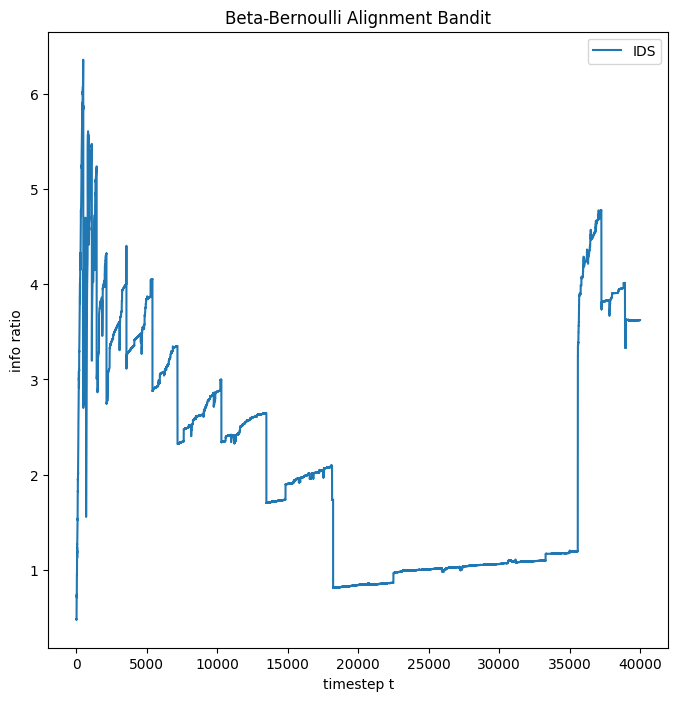

In [71]:
plt.figure(figsize=(8, 8))

for alg_name, data in grouped_df:
    if alg_name[0] != "IDS":
        continue
    means = data["info ratio mean"]
    stds = data["info ratio std"]
    plt.plot(
        np.arange(T),
        means,
        label=alg_name,
    )
    plt.fill_between(
        np.arange(T),
        means + stds,
        means - stds,
        alpha=0.3,
    )

plt.title(title)
plt.xlabel("timestep t")
plt.ylabel("info ratio")
plt.legend()
plt.show()

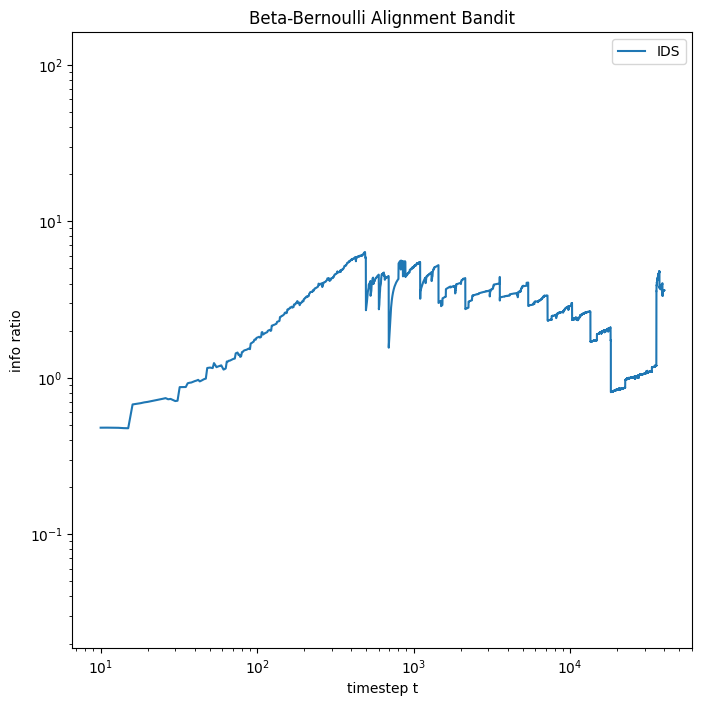

In [72]:
plt.figure(figsize=(8, 8))

for alg_name, data in grouped_df:
    means = data["info ratio mean"][10:]
    stds = data["info ratio std"][10:]
    plt.plot(
        np.arange(10, T),
        means,
        label=alg_name,
    )
    plt.fill_between(
        np.arange(10, T),
        means + stds,
        means - stds,
        alpha=0.3,
    )

plt.xscale("log")
plt.yscale("log")
plt.axis("equal")

plt.title(title)
plt.xlabel("timestep t")
plt.ylabel("info ratio")
plt.legend()
plt.show()

In [73]:
df_human_actions = (
    raw_df.with_columns(
        pl.when(pl.col("action") < K_env)
        .then(pl.lit(0))
        .otherwise(pl.lit(1))
        .alias("human action")
    )
    .with_columns(
        pl.col("human action")
        .cum_sum()
        .over("algorithm", "trial", order_by="time_step")
        .alias("cumulative human action")
    )
    .group_by("algorithm", "time_step")
    .agg(
        pl.col("cumulative human action").mean().alias("mean cum human action"),
        pl.col("cumulative human action").std().alias("std cum human action"),
    )
    .sort("time_step")
)

df_human_actions_grouped = df_human_actions.group_by("algorithm")

df_human_actions

algorithm,time_step,mean cum human action,std cum human action
cat,u32,f64,f64
"""IDS""",0,0.0,null
"""IDS""",1,0.0,null
"""IDS""",2,0.0,null
"""IDS""",3,0.0,null
"""IDS""",4,0.0,null
…,…,…,…
"""IDS""",39995,199.0,null
"""IDS""",39996,199.0,null
"""IDS""",39997,199.0,null


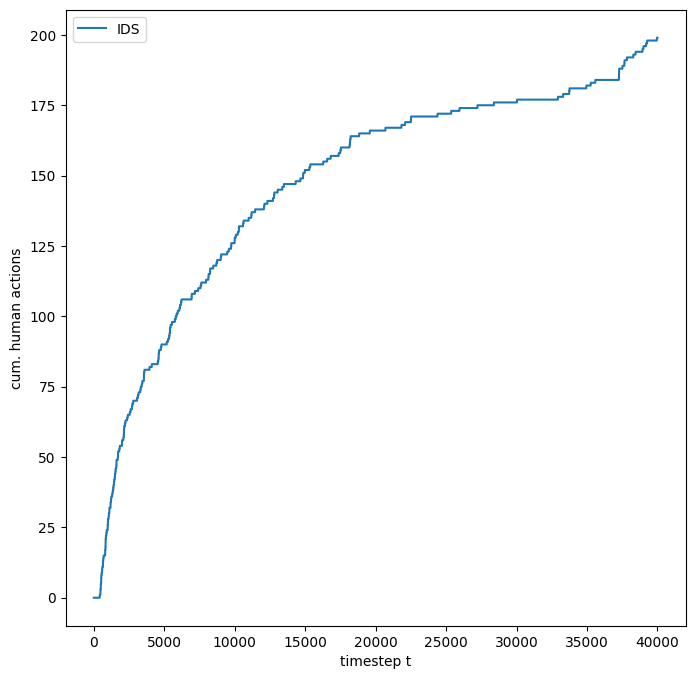

In [74]:
plt.figure(figsize=(8, 8))

for alg_name, data in df_human_actions_grouped:
    means = data["mean cum human action"]
    stds = data["std cum human action"]
    plt.plot(
        np.arange(T),
        means,
        label=alg_name,
    )
    plt.fill_between(
        np.arange(T),
        means + stds,
        means - stds,
        alpha=0.3,
    )

plt.xlabel("timestep t")
plt.ylabel("cum. human actions")
plt.legend()
plt.show()

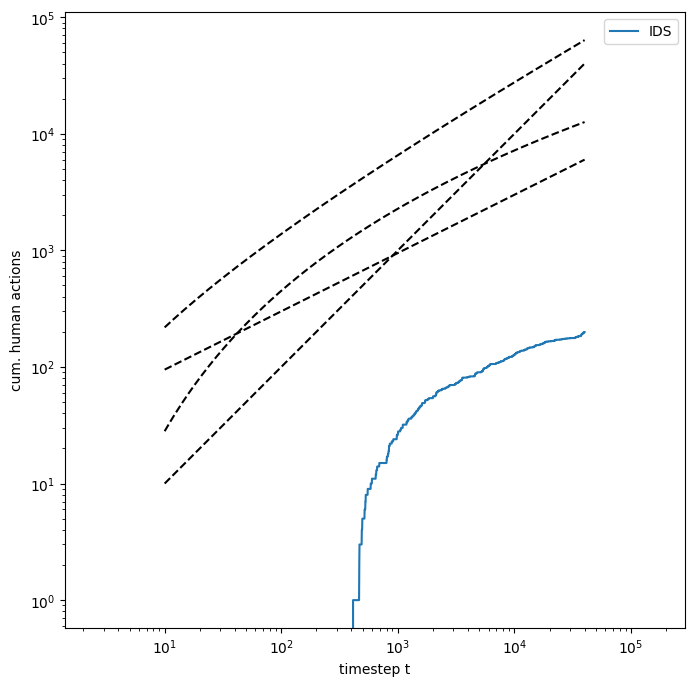

In [75]:
plt.figure(figsize=(8, 8))
for alg_name, data in df_human_actions_grouped:
    means = data["mean cum human action"][10:]
    stds = data["std cum human action"][10:]
    plt.plot(
        np.arange(10, T),
        means,
        label=alg_name,
    )
    plt.fill_between(
        np.arange(10, T),
        means + stds,
        means - stds,
        alpha=0.3,
    )

sqrt_t = np.sqrt(np.arange(10, T))
sqrt_t_log_t = np.sqrt(np.arange(10, T)) * np.log(np.arange(10, T))
log_t = np.log(np.arange(10, T)) * np.log(np.arange(10, T))

plt.plot(np.arange(10, T), np.arange(10, T), color="black", linestyle="--")
plt.plot(np.arange(10, T), 30 * sqrt_t_log_t, color="black", linestyle="--")
plt.plot(np.arange(10, T), log_t**2, color="black", linestyle="--")
plt.plot(np.arange(10, T), 30 * sqrt_t, color="black", linestyle="--")

plt.xscale("log")
plt.yscale("log")
plt.axis("equal")

plt.xlabel("timestep t")
plt.ylabel("cum. human actions")
plt.legend()
plt.show()

Let's identify one problematic seed

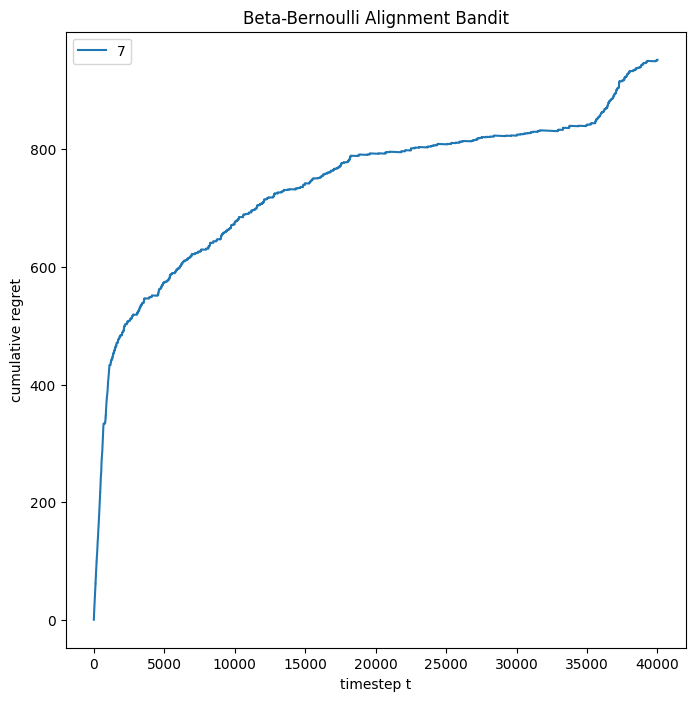

In [76]:
temp_df = (
    raw_df.filter(
        pl.col("algorithm") == "IDS",
    )
    .select("trial", "regret", "r_star", "time_step")
    .group_by("trial")
)

plt.figure(figsize=(8, 8))

for trial, data in temp_df:
    plt.plot(
        np.arange(T),
        data["regret"],
        label=trial,
    )

plt.title(title)
plt.xlabel("timestep t")
plt.ylabel("cumulative regret")
plt.legend()
plt.show()

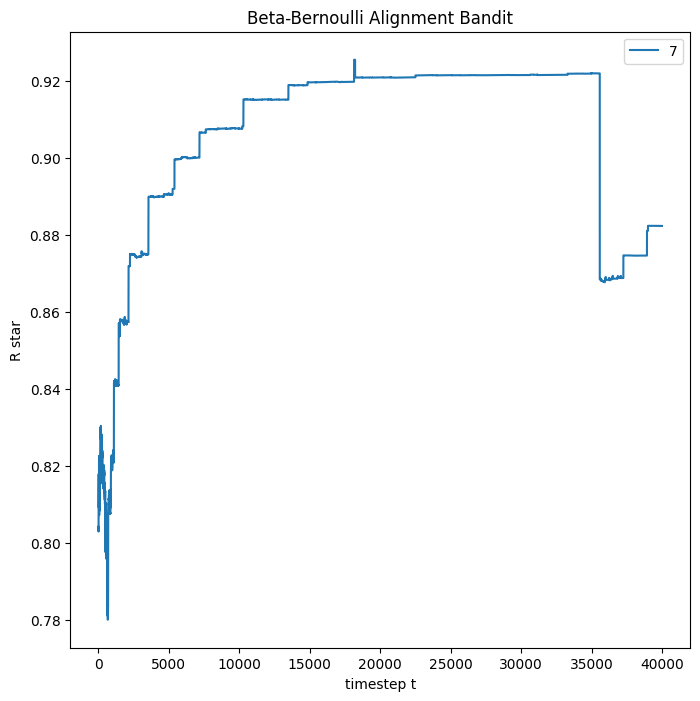

In [77]:
plt.figure(figsize=(8, 8))

for trial, data in temp_df:
    plt.plot(
        np.arange(T),
        data["r_star"],
        label=trial,
    )

plt.title(title)
plt.xlabel("timestep t")
plt.ylabel("R star")
plt.legend()
plt.show()

In [78]:
phis = bandit_env_params[0, :, 0]
thetas = bandit_env_params[0, :, 1]

true_reward_means = phis * thetas + (1 - phis) * (1 - thetas)
ic(true_reward_means)

ic| true_reward_means: array([0.72806332, 0.55950209, 0.20905411, 0.21717214, 0.34887342,
                              0.9187593 , 0.68170817, 0.41651899, 0.23346355, 0.21302616,
                              0.36493093, 0.13148024, 0.4525922 , 0.28778906, 0.42041483,
                              0.53681026])


array([0.72806332, 0.55950209, 0.20905411, 0.21717214, 0.34887342,
       0.9187593 , 0.68170817, 0.41651899, 0.23346355, 0.21302616,
       0.36493093, 0.13148024, 0.4525922 , 0.28778906, 0.42041483,
       0.53681026])